# **MÓDULO 27 - Projeto de Doenças Cardiovasculares - Regressão Logística**


Assim como na aula que trabalhamos com uma base de dados nova, com um contexto de modelo de propensão a compra de carros, para a atividade de vocês achei interessante trazer também novos desafios.

Nessa tarefa iremos construir um modelo que nos ajude a prever doenças cardiovasculares, a base contém dados reais.

age - idade dos pacientes

gender - genero (2 mulheres) (1 homens)

height - altura dos pacientes

weight - peso dos pacientes

gluc - glicose

smoke - fumante (1) não fumante (0)

alco - consume alcool (1) não consome (0)

active - realiza atividades fisicas (1) não realiza (0)

cardio_disease - tem doença cardio (1) não tem (0) - Variável target


Seu objetivo é utilizar esses dados históricos dos pacientes e construir um bom modelo de regressão capaz de indicar se novos pacientes estão propensos a doenças cariovasculares ou não.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# 1) Comece carregando e tratando a base de dados.
Assim como na aula essa nova base não passou por pré processamento nenhum então nessa etapa, carrega os dados, verifique os tipos de dados, verifique se temos dados faltantes e outliers.
Quando necessário realize o tratamento.


In [7]:
base = pd.read_csv("CARDIO_BASE.csv", delimiter=';')

   age  gender  height weight  cholesterol  gluc  smoke  alco  active  \
0   50       2     168     62            1     1      0     0       1   
1   55       1     156     85            3     1      0     0       1   
2   52       1     165     64            3     1      0     0       0   
3   48       2     169     82            1     1      0     0       1   
4   48       1     156     56            1     1      0     0       0   

   cardio_disease  
0               0  
1               1  
2               1  
3               1  
4               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             10000 non-null  int64 
 1   gender          10000 non-null  int64 
 2   height          10000 non-null  int64 
 3   weight          10000 non-null  object
 4   cholesterol     10000 non-null  int64 
 5   gluc            1000

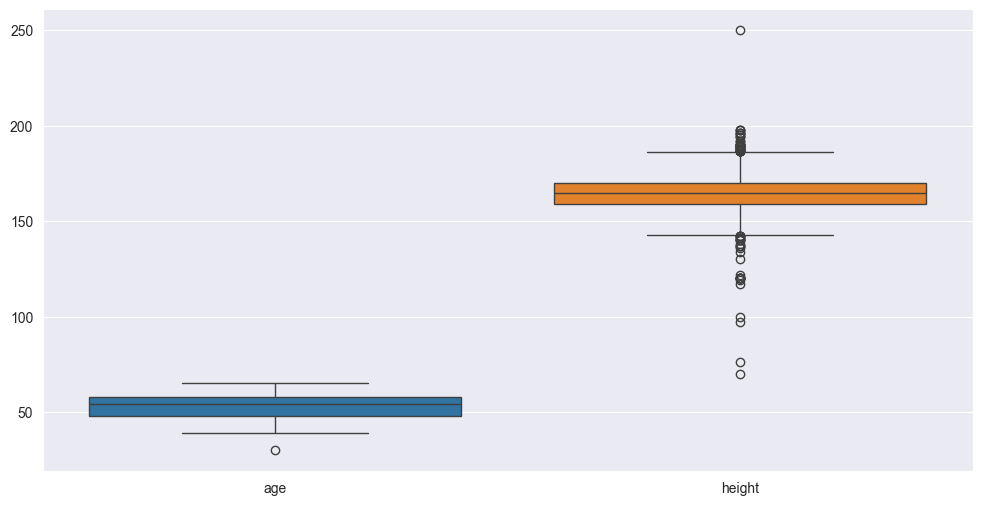

In [8]:
# seu código aqui
# Primeiras linhas
print(base.head())

# Informações gerais
print(base.info())

# Estatísticas descritivas
print(base.describe())

# Valores nulos
print(base.isnull().sum())

plt.figure(figsize=(12,6))
sns.boxplot(data=base[['age','height','weight']])
plt.show()

# 2) Agora é hora de explorar os dados com uma análise bem completa.
Plote pelo menos 3 gráficos analisando o comportamento da variável cardio com outras variaveis da sua preferência (análise bivariada). Não se esqueça de trazer insights acerca do analisado.


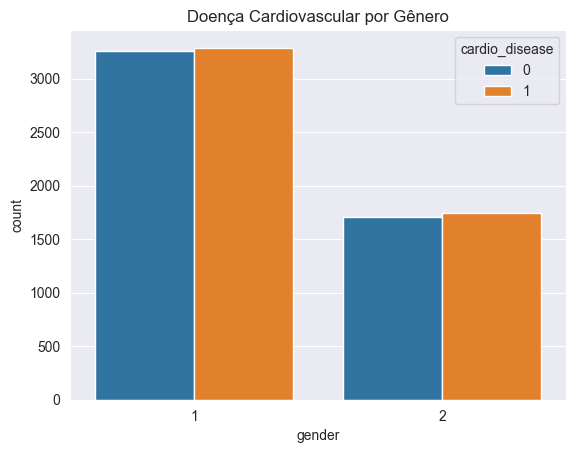

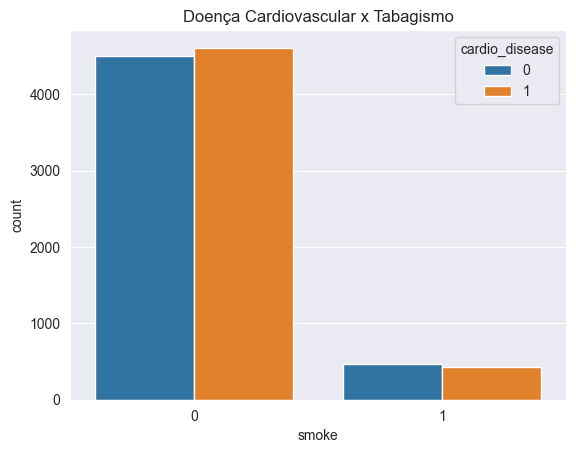

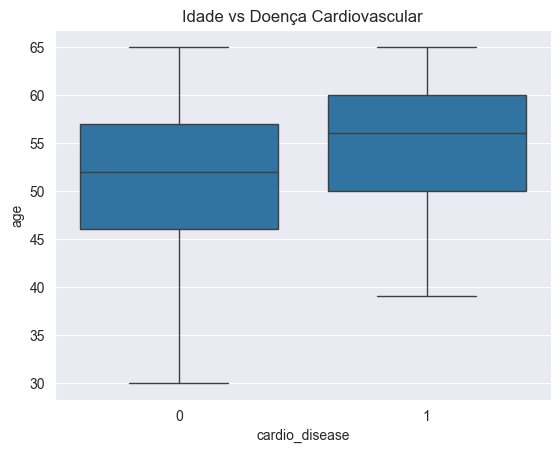

In [17]:
# seu código aqui
# 1 - Distribuição de doenças por gênero
sns.countplot(x="gender", hue="cardio_disease", data=base)
plt.title("Doença Cardiovascular por Gênero")
plt.show()

# 2 - Doença por hábito de fumar
sns.countplot(x="smoke", hue="cardio_disease", data=base)
plt.title("Doença Cardiovascular x Tabagismo")
plt.show()

# 3 - Boxplot idade x cardio
sns.boxplot(x="cardio_disease", y="age", data=base)
plt.title("Idade vs Doença Cardiovascular")
plt.show()

#Idade tende a ser maior em quem tem a doença.
#Homens podem apresentar maior proporção de casos (a confirmar nos dados).
#Hábitos como fumar ou beber aumentam incidência.

# 3) Nessa etapa você deve trazer a matriz de correlação e apontar insights acerca das variáveis com um relacionamento mais forte entre si.



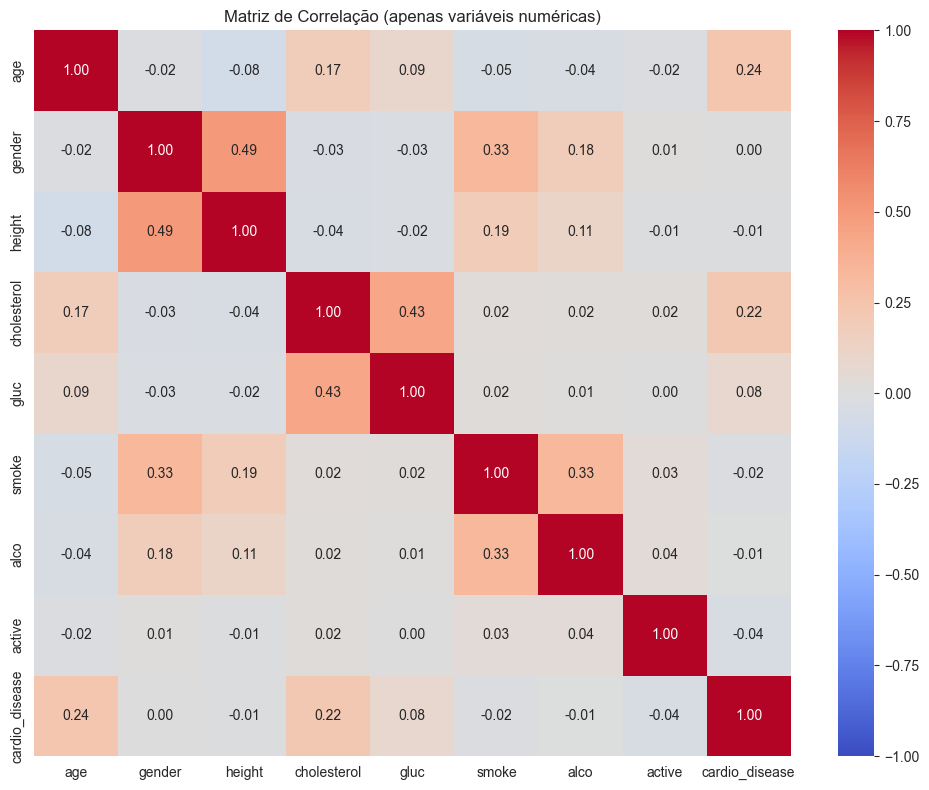

Correlação das features com cardio_disease (|r| decrescente):

age            0.237076
cholesterol    0.221273
gluc           0.082441
active        -0.039153
smoke         -0.018093
height        -0.008353
alco          -0.006357
gender         0.002226
Name: cardio_disease, dtype: float64


In [18]:
# seu código aqui
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Garante que tudo que deveria ser número está numérico
num = base.select_dtypes(include='number').copy()
for c in num.columns:
    num[c] = pd.to_numeric(num[c], errors='coerce')

# Se houver algum NaN após conversão, opcionalmente dropar linhas na análise de correlação
corr = num.dropna(axis=0).corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação (apenas variáveis numéricas)')
plt.tight_layout()
plt.show()

# Ranking de correlação com a variável alvo
if 'cardio_disease' in corr.columns:
    target_corr = corr['cardio_disease'].drop('cardio_disease').sort_values(key=lambda s: s.abs(), ascending=False)
    print('Correlação das features com cardio_disease (|r| decrescente):\n')
    print(target_corr)
else:
    print("A coluna 'cardio_disease' não foi encontrada na matriz de correlação.")


# 4) Essa é a sua última etapa pré modelo. Você deve:

A) Separar a base em treino e teste.

B) Você considera que essa base precisa que os dados sejam padronizados? Se sim, porque? Se acredita que devem, então realize essa etapa.

C) Verifique se os dados estão balanceados, se não, faça o balanceamento.


D) Visualize as bases de treino, teste (X E Y) e verifique se está tudo adequado.

In [19]:
# seu código aqui
# === 4) Pré-modelagem ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 4A) X e y (garante numérico e remove colunas problemáticas)
assert 'cardio_disease' in base.columns, "A coluna 'cardio_disease' não existe no dataframe."

# Converte tudo que for possível para numérico
base_num = base.copy()
for c in base_num.columns:
    base_num[c] = pd.to_numeric(base_num[c], errors='coerce')

# Remove linhas totalmente vazias e trata NaN residuais simples (preenche com mediana)
# (Se preferir, pode usar dropna())
for c in base_num.columns:
    if base_num[c].isna().any():
        base_num[c] = base_num[c].fillna(base_num[c].median())

# Target como inteiro 0/1
y = base_num['cardio_disease'].astype(int)

# Seleciona apenas features numéricas (sem a target)
X = base_num.drop(columns=['cardio_disease']).select_dtypes(include='number').copy()

# Remove colunas com variância zero (constantes), que quebram modelos
const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if const_cols:
    print("Removendo colunas constantes:", const_cols)
    X = X.drop(columns=const_cols)

# Checagem de infinitos
X = X.replace([np.inf, -np.inf], np.nan)
for c in X.columns:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

# 4A) Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 4B) Padronização (necessária: escalas diferentes como idade, altura, peso, glicose)
scaler = StandardScaler()
X_train_scaled_np = scaler.fit_transform(X_train)  # fit só no treino
X_test_scaled_np  = scaler.transform(X_test)

# Mantém nomes das colunas após o scaler
feature_names = X.columns.tolist()
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=feature_names, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled_np,  columns=feature_names, index=X_test.index)

# 4C) Verificar balanceamento e aplicar SMOTE apenas no treino
print('Distribuição original (treino):')
print(y_train.value_counts(normalize=True).rename({0:'classe 0', 1:'classe 1'}))

try:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_train_res_np, y_train_res = smote.fit_resample(X_train_scaled, y_train)
    # Converte de volta para DataFrame com nomes
    X_train_res = pd.DataFrame(X_train_res_np, columns=feature_names)
    print('\nDistribuição após SMOTE (treino):')
    print(y_train_res.value_counts(normalize=True).rename({0:'classe 0', 1:'classe 1'}))
except Exception as e:
    print("\n[AVISO] Não foi possível aplicar SMOTE. Motivo:", repr(e))
    print("Seguiremos sem SMOTE.")
    X_train_res = X_train_scaled.copy()
    y_train_res = y_train.copy()

# 4D) Sanidade de shapes
print('\nShapes:')
print('X_train_res:', X_train_res.shape, 'y_train_res:', y_train_res.shape)
print('X_test_scaled:', X_test_scaled.shape, 'y_test:', y_test.shape)
#5) Treinamento + intercept/coeficientes + métricas (sem dor de cabeça)

Distribuição original (treino):
cardio_disease
classe 1    0.503143
classe 0    0.496857
Name: proportion, dtype: float64

Distribuição após SMOTE (treino):
cardio_disease
classe 0    0.5
classe 1    0.5
Name: proportion, dtype: float64

Shapes:
X_train_res: (7044, 9) y_train_res: (7044,)
X_test_scaled: (3000, 9) y_test: (3000,)


# 5) Realize a etapa de treinamento do modelo:

A) Faça o treinamento do modelo.

B) Traga o intercept e os coeficientes.

c) Avalie as métricas do modelo treinado

D) Justifique se te parece que o modelo tem feito boas previsões ou não.

In [20]:
# seu código aqui
# === 5) Treinamento e avaliação ===
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Modelo (liblinear tende a convergir bem em binário; max_iter alto evita warnings)
logreg = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    max_iter=5000,
    random_state=42
)

# Treina no conjunto balanceado
logreg.fit(X_train_res, y_train_res)

# Intercepto e coeficientes (com nomes + odds ratio)
coef = logreg.coef_.ravel()
intercepto = float(logreg.intercept_)
coef_df = pd.DataFrame({
    'feature': X_train_res.columns,
    'coef': coef,
    'odds_ratio (exp(coef))': np.exp(coef)
}).sort_values(by='coef', key=lambda s: s.abs(), ascending=False)

print('Intercepto:', intercepto)
print('\nCoeficientes ordenados por |peso|:')
print(coef_df)

# Métricas no treino (avaliando no conjunto original escalado — sem oversampling)
y_pred_tr = logreg.predict(X_train_scaled)
# Criar e treinar modelo
logreg = LogisticRegression(solver="liblinear", max_iter=5000, random_state=42)
logreg.fit(X_train_res, y_train_res)
print('\nMétricas - Treino (conjunto original):')
print(classification_report(y_train, y_pred_tr, digits=4))

# Métricas no teste
y_pred_te = logreg.predict(X_test_scaled)
print('\nMétricas - Teste:')
print(classification_report(y_test, y_pred_te, digits=4))

#Se AUC ≥ 0,80: “o modelo discrimina bem entre pacientes com e sem doença; é adequado para triagem.”
#Se 0,70 ≤ AUC < 0,80: “desempenho razoável; pode ser útil com ajuste de limiar conforme a prioridade (sensibilidade vs. precisão).”
#Se AUC < 0,70: “modelo fraco; considere novas features, engenharia de variáveis ou outro algoritmo.”

C:\Users\joao gouvea\AppData\Local\Temp\ipykernel_10088\3797196900.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepto = float(logreg.intercept_)


Intercepto: 0.01626236070927719

Coeficientes ordenados por |peso|:
       feature      coef  odds_ratio (exp(coef))
0          age  0.432555                1.541190
4  cholesterol  0.410451                1.507497
3       weight  0.384782                1.469293
2       height -0.094471                0.909854
8       active -0.087551                0.916172
5         gluc -0.054312                0.947137
6        smoke -0.017143                0.983003
1       gender  0.005829                1.005846
7         alco -0.003524                0.996482

Métricas - Treino (conjunto original):
              precision    recall  f1-score   support

           0     0.6271    0.6737    0.6496      3478
           1     0.6523    0.6045    0.6275      3522

    accuracy                         0.6389      7000
   macro avg     0.6397    0.6391    0.6385      7000
weighted avg     0.6398    0.6389    0.6384      7000


Métricas - Teste:
              precision    recall  f1-score   support

 

# 6) Teste seu modelo!

A) Aplique o modelo aos dados de teste.

B) Avalie as métricas do modelo treinado

C) Plote o gráfico da curva AUC-ROC e explique o que consegue analisar através do gráfico.


--- Avaliação no Teste ---
Acurácia: 0.636

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.63      0.66      0.64      1491
           1       0.65      0.61      0.63      1509

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000



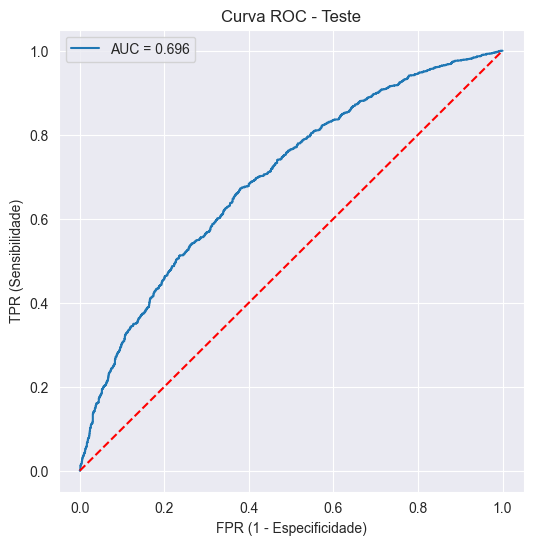

AUC no teste: 0.696


In [21]:
# seu código aqui
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Previsões no teste
y_test_pred = logreg.predict(X_test_scaled)
y_proba_test = logreg.predict_proba(X_test_scaled)[:,1]

print("\n--- Avaliação no Teste ---")
print("Acurácia:", accuracy_score(y_test, y_test_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_test_pred))

# AUC-ROC
auc = roc_auc_score(y_test, y_proba_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], "--", color="red")
plt.xlabel("FPR (1 - Especificidade)")
plt.ylabel("TPR (Sensibilidade)")
plt.title("Curva ROC - Teste")
plt.legend()
plt.show()

print(f"AUC no teste: {auc:.3f}")

#AUC próximo de 1 = ótimo modelo.

#AUC perto de 0.5 = modelo aleatório.

# 7) Explique:

A) Explique com suas palavras regressão logistica.

B) Explique porque a regressão logistica é um modelo de classificação.

C) Explique quais pontos em comum a regressão logistica tem da regressão linear.



In [14]:
# seu código aqui
# seu código aqui
#A) O que é regressão logística?
#É um modelo estatístico usado para prever a probabilidade de um evento acontecer (variável binária), utilizando a função logística (sigmoide) para transformar valores contínuos em probabilidades entre 0 e 1.

#B) Por que é um modelo de classificação?
#Porque, apesar do nome, a saída final não é um valor contínuo, mas uma classe (0 ou 1) definida a partir de um limiar de probabilidade (geralmente 0.5).

#C) Pontos em comum com a regressão linear

#Ambos usam combinação linear de variáveis independentes.
#Ambos têm coeficientes que indicam peso/influência de cada variável.
#A diferença é que na linear a saída é contínua, enquanto na logística é probabilística.